In [1]:
import pandas as pd
import os, re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


In [4]:
def load_image_csvs(path="image_csv"):
    train_folder=os.path.join(os.getcwd(),path,"train")
    test_folder=os.path.join(os.getcwd(),path,"test")
    
    X_train, X_test, Y_train, Y_test = [],[],[],[]
    
    # loading images from train folder to X_train and label to y_train
    train_count = 0
    for image_fname in os.listdir(train_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.csv',image_fname)
        
        # process preprocessed image into normalised flattened numpy array
        image = np.loadtxt(os.path.join(train_folder,image_fname),delimiter=',',dtype=np.float32)
        label = image_re.group(2)
        
        X_train.append(image)
        Y_train.append(int(label))
        train_count+=1
        if train_count % 1000==0:
            print(train_count)
    print("Loaded train folder")
    
    # loading images from test folder to X_test and label to y_test
    test_count = 0
    for image_fname in os.listdir(test_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.csv',image_fname)
        
        # process preprocessed image into normalised flattened numpy array
        image = np.loadtxt(os.path.join(test_folder,image_fname),delimiter=',',dtype=np.float32)
        # assert image.shape == (240,240)
        # image = image.reshape(240*240)
        # image = image.astype('float32')
        # image /= 255
        # image = np.asarray(image).astype('float32')
        
        label = image_re.group(2)
        
        X_test.append(image)
        Y_test.append(int(label))
        test_count+=1
        if test_count % 1000==0:
            print(test_count)
    print("Loaded test folder")
    
    return np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)

In [5]:
X_train, X_test, Y_train, Y_test = load_image_csvs()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Loaded train folder
1000
Loaded test folder


In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /=255

In [8]:
from keras.utils import to_categorical

print("Shape before one-hot encoding : ",y_train.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Shape after one-hot encoding : ",y_test.shape)


Shape before one-hot encoding :  (10618,)
Shape after one-hot encoding :  (1405, 4)


In [9]:
x_train

array([[[0.01176471, 0.01176471, 0.01176471, ..., 0.00784314,
         0.01176471, 0.01176471],
        [0.00784314, 0.01176471, 0.01176471, ..., 0.01176471,
         0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471, ..., 0.01176471,
         0.01176471, 0.01176471],
        ...,
        [0.03529412, 0.03529412, 0.04313726, ..., 0.04705882,
         0.04705882, 0.04705882],
        [0.03529412, 0.03137255, 0.03137255, ..., 0.04705882,
         0.04705882, 0.04705882],
        [0.03529412, 0.03529412, 0.03137255, ..., 0.04705882,
         0.04313726, 0.03921569]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [10]:
y_train

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [19]:
with tf.device('/CPU:0'):
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [20]:
batch_size= 32

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

"""Also btw you can unbatch using .unbatch() method"""
train_ds_rgb_final = configure_for_performance(train_ds)
test_ds_rgb_final = configure_for_performance(test_ds)

In [23]:
# Example usage of the transformed datasets
for image_batch, label in train_ds_rgb_final.take(1):
    # print(image)  # Should print (height, width, 3)
    print(image_batch.shape)  # Should print (height, width, 3)
    print(label.shape)  # Print the label of the image

for image, label in test_ds_rgb_final.take(1):
    # print(image)  # Should print (height, width, 3)
    print(image.shape)  # Should print (height, width, 3)
    print(label.shape)  # Print the label of the image

(32, 240, 240)
(32, 4)
(32, 240, 240)
(32, 4)


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model with dropout layers
def create_model_with_dropout(input_shape=(240, 240, 1), num_classes=4):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape, padding = 'same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten layer
    model.add(layers.Flatten())
    
    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer
    model.add(layers.Dense(4, activation='sigmoid'))
    # 6/17/2024 try softmax
    #model.add(layers.Dense(4, activation='softmax'))
    
    return model

# Create an instance of the model
model = create_model_with_dropout()

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 240, 240, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)      

In [26]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [15]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [28]:
history = model.fit(train_ds_rgb_final, epochs=12, validation_data=test_ds_rgb_final)

Epoch 1/12
332/332 [==============================] - 30s 71ms/step - loss: 1.2324 - accuracy: 0.3865 - val_loss: 0.9119 - val_accuracy: 0.6242
Epoch 2/12
332/332 [==============================] - 22s 67ms/step - loss: 0.9105 - accuracy: 0.6090 - val_loss: 0.7585 - val_accuracy: 0.7018
Epoch 3/12
332/332 [==============================] - 22s 67ms/step - loss: 0.7796 - accuracy: 0.6792 - val_loss: 0.5579 - val_accuracy: 0.8107
Epoch 4/12
332/332 [==============================] - 22s 67ms/step - loss: 0.6832 - accuracy: 0.7199 - val_loss: 0.5118 - val_accuracy: 0.8185
Epoch 5/12
332/332 [==============================] - 23s 68ms/step - loss: 0.5843 - accuracy: 0.7658 - val_loss: 0.4007 - val_accuracy: 0.8555
Epoch 6/12
332/332 [==============================] - 23s 68ms/step - loss: 0.5071 - accuracy: 0.8025 - val_loss: 0.3400 - val_accuracy: 0.8641
Epoch 7/12
332/332 [==============================] - 23s 68ms/step - loss: 0.4163 - accuracy: 0.8360 - val_loss: 0.2709 - val_accuracy:

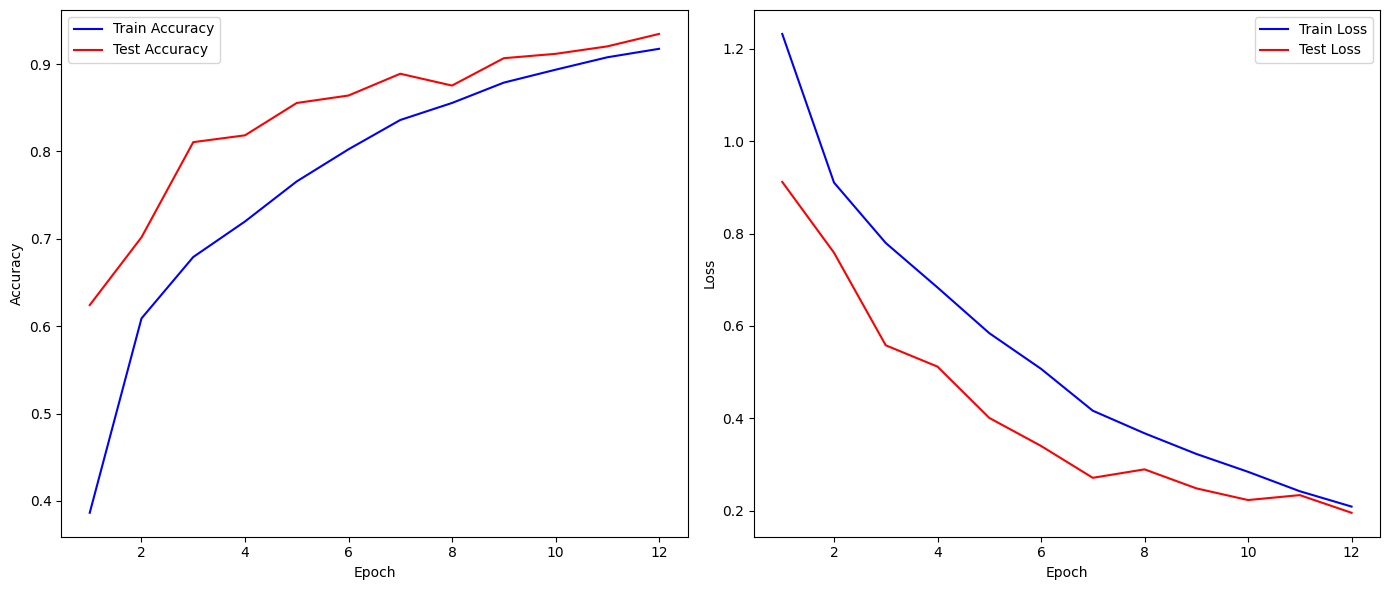

In [29]:
import matplotlib.pyplot as plt

acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1,len(acc2)+1)
 
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
 
axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
 
axes[1].plot(epochs, loss2,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
 
# Adjusting layout for better spacing
plt.tight_layout()
 
# Display the figure
plt.show()

In [61]:
import numpy as np
from sklearn.metrics import classification_report

predict_x = model.predict(x_test)
predict1 = np.argmax(predict_x, axis = 1)
print(predict1)

target_names = ["Class {}".format(i) for i in range(4)]
print(classification_report(np.array([int(class_) for class_ in Y_test]), predict1, target_names = target_names))

44/44 [==============================] - 1s 19ms/step
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

     Class 0       0.90      0.92      0.91       309
     Class 1       0.90      0.89      0.89       335
     Class 2       0.97      0.96      0.96       399
     Class 3       0.94      0.95      0.95       362

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.93      0.93      0.93      1405



In [1]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [46]:
import tensorflow
import keras_tuner
import 

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from kerastuner import HyperModel

def build_model(hp):
    model = models.Sequential()
    
    # Convolutional layers
    # max_value set to 32 cause if the first two layer too big the model accuracy will be very low
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=32, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(240, 240, 1),
        padding='same'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    # same as layer 1
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=32, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=64, max_value=128, step=64),
        kernel_size=hp.Choice('conv_4_kernel', values=[3, 5]),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten layer
    model.add(layers.Flatten())
    
    # Dense layers
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=128, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(4, activation = hp.Choice('output_activation', values=['softmax', 'sigmoid'])))
    
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model

In [47]:
# Define the tuner
tuner_random_3 = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search_dir_3',
    project_name='cnn_hyperparameter'
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 120, 120, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 30, 32)      

In [48]:
tuner_random_3.search_space_summary()

Search space summary
Default search space size: 12
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 32, 'step': 32, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 32, 'step': 32, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_4_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 64, 'sampling': 'linear'}
conv_4_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128,

In [53]:
# tuner_random_3.search(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_test, y_test))
tuner_random_3.search(
    train_ds_rgb_final, 
    epochs=10, 
    validation_data=test_ds_rgb_final, 
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir="./random_search_dir_3/tb_logs", histogram_freq=1)],
    )

Trial 10 Complete [00h 04m 28s]
val_accuracy: 0.9416370391845703

Best val_accuracy So Far: 0.9416370391845703
Total elapsed time: 00h 56m 51s


In [66]:
# Retrieve the best model
# You need to retrieve the hyperparametre for training, not the model, cuz otherwise just train the model again which leads to overfitting
best_hps = tuner_random_3.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner_random_3.hypermodel.build(best_hps)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 32)        25632     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 32)      

In [62]:
def zbest_model2(input_shape=(240, 240, 1), num_classes=4):
    model = models.Sequential()
    
    # Convolutional layers
    # max_value set to 32 cause if the first two layer too big the model accuracy will be very low
    model.add(layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation='relu',
        input_shape=(240, 240, 1),
        padding='same'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    # same as layer 1
    model.add(layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten layer
    model.add(layers.Flatten())
    
    # Dense layers
    model.add(layers.Dense(
        units=128,
        activation='relu'
    ))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(4, activation = "softmax"))
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [68]:
best_modelz2 = zbest_model2()
best_modelz2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 120, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 32)        25632     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 32)      

In [69]:
history = best_modelz2.fit(train_ds_rgb_final, epochs=10, validation_data=test_ds_rgb_final)

Epoch 1/10
332/332 [==============================] - 27s 80ms/step - loss: 0.9872 - accuracy: 0.5547 - val_loss: 0.7691 - val_accuracy: 0.6847
Epoch 2/10
332/332 [==============================] - 27s 80ms/step - loss: 0.7065 - accuracy: 0.7154 - val_loss: 0.5921 - val_accuracy: 0.7851
Epoch 3/10
332/332 [==============================] - 26s 79ms/step - loss: 0.5598 - accuracy: 0.7773 - val_loss: 0.4271 - val_accuracy: 0.8441
Epoch 4/10
332/332 [==============================] - 26s 79ms/step - loss: 0.4332 - accuracy: 0.8358 - val_loss: 0.2919 - val_accuracy: 0.8840
Epoch 5/10
332/332 [==============================] - 26s 80ms/step - loss: 0.3405 - accuracy: 0.8723 - val_loss: 0.2595 - val_accuracy: 0.9032
Epoch 6/10
332/332 [==============================] - 26s 78ms/step - loss: 0.2577 - accuracy: 0.8999 - val_loss: 0.2492 - val_accuracy: 0.9089
Epoch 7/10
332/332 [==============================] - 26s 78ms/step - loss: 0.1993 - accuracy: 0.9257 - val_loss: 0.2256 - val_accuracy:

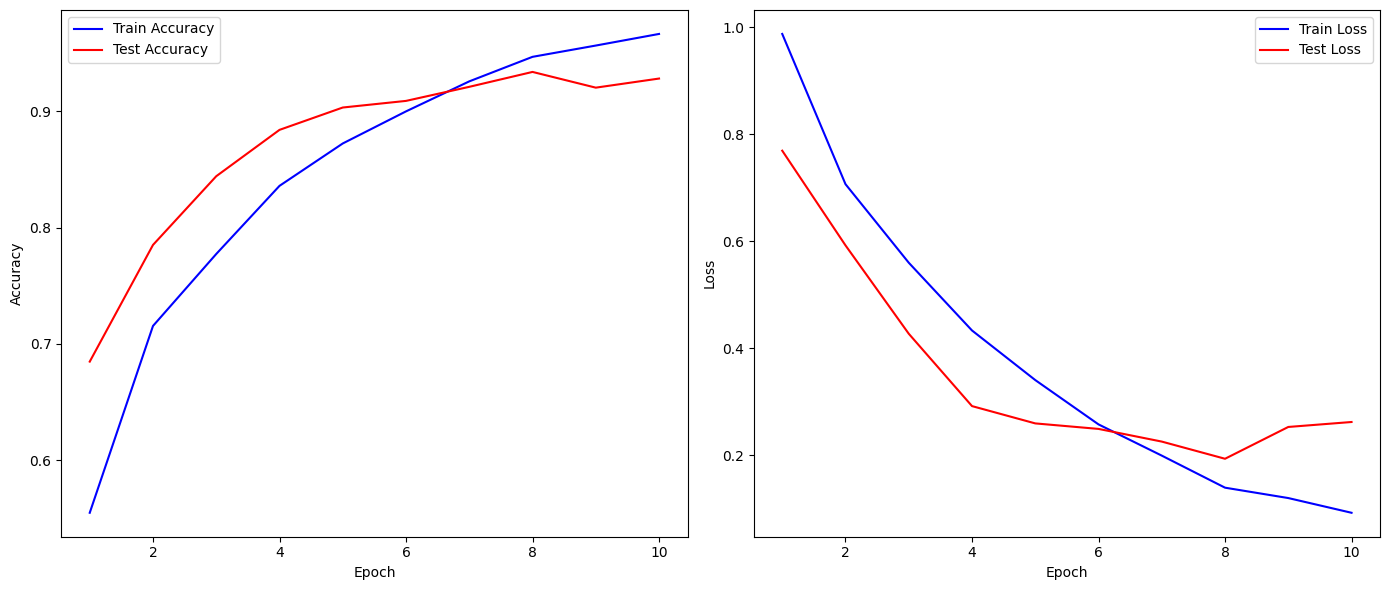

In [70]:
import matplotlib.pyplot as plt

acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1,len(acc2)+1)
 
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
 
axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
 
axes[1].plot(epochs, loss2,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
 
# Adjusting layout for better spacing
plt.tight_layout()
 
# Display the figure
plt.show()

In [71]:
import numpy as np
from sklearn.metrics import classification_report

predict_x = best_modelz2.predict(x_test)
predict1 = np.argmax(predict_x, axis = 1)
print(predict1)

target_names = ["Class {}".format(i) for i in range(4)]
print(classification_report(np.array([int(class_) for class_ in Y_test]), predict1, target_names = target_names))

44/44 [==============================] - 1s 18ms/step
[1 0 2 ... 0 0 0]
              precision    recall  f1-score   support

     Class 0       0.97      0.84      0.90       309
     Class 1       0.90      0.90      0.90       335
     Class 2       0.97      0.97      0.97       399
     Class 3       0.88      0.98      0.93       362

    accuracy                           0.93      1405
   macro avg       0.93      0.92      0.93      1405
weighted avg       0.93      0.93      0.93      1405

